In [1]:
from main import *
import numpy as np

# parameter setup

In [2]:
target_feature = "merged_support3_variance_0.1_random_1M"
target_feature_suffix = "_matrix.npy"
save_data_path = "./results"

select_methods = ["rf"]# ["random", "xgb", "rf", "variance", "chi2", "f_classif"] # Extra-trees # "mutual_info_classif"
    
n_select_list = [256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072] #5105448
n_dim_reduce_list = [128, 256, 512, 1024, None]  ## list should always contain None to perform whole feature training after selection
ML_models = ["SVM"] #["SVM", "XGB", "RF", "DT", "KNN"]

# data loading

In [3]:
feature_data_path, sample_annotation_file = get_data_path(save_data_path)

dataset = data_loader(os.path.join(feature_data_path, target_feature + target_feature_suffix), 
                        sample_annotation_file)
(X, y_original, y), (train_indices, val_indices, test_indices), label_mapping = dataset.get_data()


result_combined = []

2024-05-10 11:41:15,360 - INFO - [progress] Read data done. X.shape: (3202, 1048576), y.shape: (3202,)
2024-05-10 11:41:28,337 - INFO - [progress] Dropped 709 samples from the dataset. X.shape: (2493, 1048576), y.shape: (2493,)
2024-05-10 11:41:28,641 - INFO -  - Data_split: train_set (n= 1495), val_set (n= 499), test_set (n= 499)


# save feature selection result

In [4]:
n = 8192
save_file_name = os.path.join(feature_data_path, target_feature + f"_xgb_{n}" + target_feature_suffix)

X = np.load(os.path.join(feature_data_path, target_feature + target_feature_suffix))
feature_importance_use = np.load(f"1048576_seed42_xgb_basic_feature_importance_mean.npy")
selected_indices = np.argsort(feature_importance_use)[-n:][::-1]
X_selected = X[:, selected_indices]
np.save(save_file_name, X_selected)

print(f"saved result to {save_file_name} with shape {X_selected.shape}")

saved result to /project/datacamp/team11/data/preprocessed/merged_support3_variance_0.1_random_1M_xgb_8192_matrix.npy with shape (3202, 8192)


/home/jinhyun/anaconda3/envs/geography/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/jinhyun/anaconda3/envs/geography/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/jinhyun/anaconda3/envs/geography/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/jinhyun/anaconda3/envs/geography/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloadi

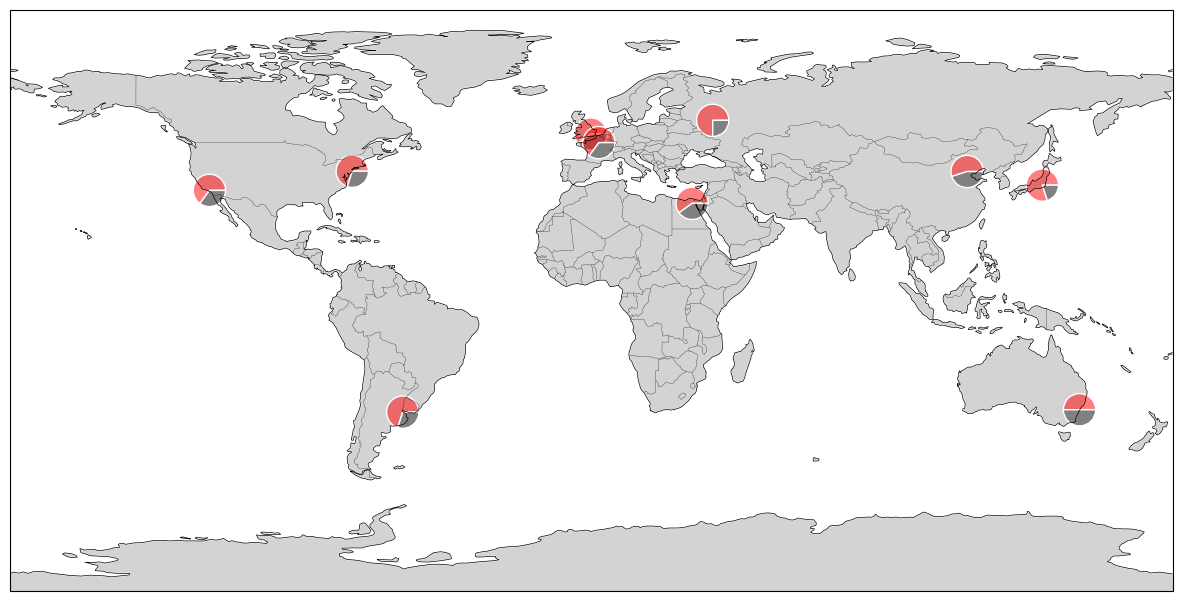

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Wedge

def draw_pie_charts_on_map(cities):
    """
    주어진 도시 목록에 대해 고해상도 세계지도 위에 파이 차트를 그립니다.

    Parameters:
    cities (list of dicts): 도시 정보를 담고 있는 리스트. 각 항목은 다음 키를 가짐:
        - name (str): 도시 이름
        - lon (float): 경도
        - lat (float): 위도
        - value (float): 파이 차트에서 첫 번째 조각의 비율
        - radius (float): 파이 차트의 크기
    """
    # 평면 지도 생성
    fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_global()

    # 고해상도 해안선과 국경
    coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '110m', edgecolor='black', facecolor='none', linewidth=0.5)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '110m', edgecolor='black', facecolor='none', linewidth=0.2)
    ax.add_feature(coastline)
    ax.add_feature(borders)
    ax.add_feature(cfeature.LAND, color='lightgrey')
    ax.add_feature(cfeature.OCEAN, color='white')

    # 각 도시에 대해 파이 차트 그리기
    for city in cities:
        sizes = [city['value'], 1 - city['value']]  # 파이 차트 비율
        colors = [(1, 0, 0, 0.5), 'grey']  # 빨간색과 회색
        start_angle = 0
        for size, color in zip(sizes, colors):
            angle = 360 * size
            wedge = Wedge(center=(city['lon'], city['lat']), r=city['radius'],
                          theta1=start_angle, theta2=start_angle + angle,
                          edgecolor='white', facecolor=color, transform=ccrs.Geodetic())
            ax.add_patch(wedge)
            start_angle += angle

    plt.show()

# 도시 목록 설정
cities = [
    {'name': 'New York', 'lon': -74, 'lat': 40, 'value': 0.7, 'radius': 5},
    {'name': 'London', 'lon': -0.1276, 'lat': 51.5074, 'value': 0.6, 'radius': 5},
    {'name': 'Tokyo', 'lon': 139.6917, 'lat': 35.6895, 'value': 0.8, 'radius': 5},
    {'name': 'Sydney', 'lon': 151.2093, 'lat': -33.8688, 'value': 0.5, 'radius': 5},
    {'name': 'Paris', 'lon': 2.3522, 'lat': 48.8566, 'value': 0.65, 'radius': 5},
    {'name': 'Moscow', 'lon': 37.6173, 'lat': 55.7558, 'value': 0.75, 'radius': 5},
    {'name': 'Beijing', 'lon': 116.4074, 'lat': 39.9042, 'value': 0.55, 'radius': 5},
    {'name': 'Cairo', 'lon': 31.2357, 'lat': 30.0444, 'value': 0.6, 'radius': 5},
    {'name': 'Buenos Aires', 'lon': -58.3816, 'lat': -34.6037, 'value': 0.7, 'radius': 5},
    {'name': 'Los Angeles', 'lon': -118.2437, 'lat': 34.0522, 'value': 0.65, 'radius': 5}
]

draw_pie_charts_on_map(cities)
